<div style="background-color:#11288F; padding:10px; border-radius:8px; text-align:left; color:white; font-size:28px; font-weight:SEMI_BOLD;">
Predicting Road Accident Risk - EDA
</div>




Problem Statement-

The task is to develop a supervised machine learning model capable of predicting the risk of a road accident given structured input features describing environmental, temporal, and road conditions.
Formally, this is a regression problem where the target variable represents a continuous risk score ranging from 0 (low risk) to 1 (high risk), indicating the likelihood of a road accident occurring.

The dataset includes variables such as weather type, visibility, road surface condition, light conditions, and time-related features, which are expected to have non-linear relationships with accident likelihood.

Goal-

Build an accurate regression model to predict road accident risk, minimizing Root Mean Squared Error (RMSE) on test data. 
The model pipeline should include data preprocessing (handling missing values, outliers, categorical encoding), feature engineering (interactions, cyclical encoding of time), model training and comparison of multiple algorithms.

### Import Libraries and Data




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.core.reshape.encoding import get_dummies
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


### Data Overview

In [3]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [6]:
train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [7]:
print("Missing values in train:", sum(train.isnull().sum()))
print("Missing values in test:", sum(test.isnull().sum()))


Missing values in train: 0
Missing values in test: 0


In [8]:
print("Duplicate values in train:", train.duplicated().sum())
print("Duplicate values in test:", test.duplicated().sum())



Duplicate values in train: 0
Duplicate values in test: 0


In [9]:
#check columns in test and train are same or not
train.columns[:-1] == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Key findings and column description
</div>

The dataset contains 517,754 rows and 14 columns.
It includes a mix of numerical, categorical, boolean, and one target column (accident_risk).
The data covers road characteristics, environmental factors, and contextual conditions that influence accident probability.

| Column                   | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| `id`                     | Unique identifier for each record.                           |
| `road_type`              | Type of road (e.g., highway, urban, rural).                  |
| `num_lanes`              | Number of lanes on the road segment.                         |
| `curvature`              | Degree of road curvature — higher values mean sharper turns. |
| `speed_limit`            | Maximum legal speed on that segment.                         |
| `lighting`               | Lighting condition (daylight, dusk, dark, etc.).             |
| `weather`                | Weather during observation (clear, rain, fog, etc.).         |
| `road_signs_present`     | Whether road signs are present.                              |
| `public_road`            | Indicates if the segment is a public road.                   |
| `time_of_day`            | Time category (morning, afternoon, night).                   |
| `holiday`                | Whether it was a holiday.                                    |
| `school_season`          | Indicates if school season was active.                       |
| `num_reported_accidents` | Number of past reported accidents in that area.              |
| `accident_risk`          | **Target variable** — predicted risk of an accident (0–1).   |


Road features: Most have 2 lanes, gentle to moderate curves, and speed limits around 45.

Accidents: Usually 1–2 reported accidents per segment.

Target (accident_risk): Between 0 and 1, averages ~0.35, with no obvious outliers.

There are no missing or duplicated values in the dataset, and the train and test dataset have same columns.

In [10]:
#numeric and categorical feature list removing the target variable and id 
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_features.drop(['id', 'accident_risk'])

categorical_features = train.select_dtypes(include=['object']).columns
boolean_features = train.select_dtypes(include=['bool']).columns

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Boolean features:", boolean_features)


Numeric features: Index(['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents'], dtype='object')
Categorical features: Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')
Boolean features: Index(['road_signs_present', 'public_road', 'holiday', 'school_season'], dtype='object')


### Exploratory Data Analysis

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Distribution of the target variable
</div>



/var/folders/j4/87r164g571g19hxdqwwwrgr00000gn/T/ipykernel_88013/1953924325.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


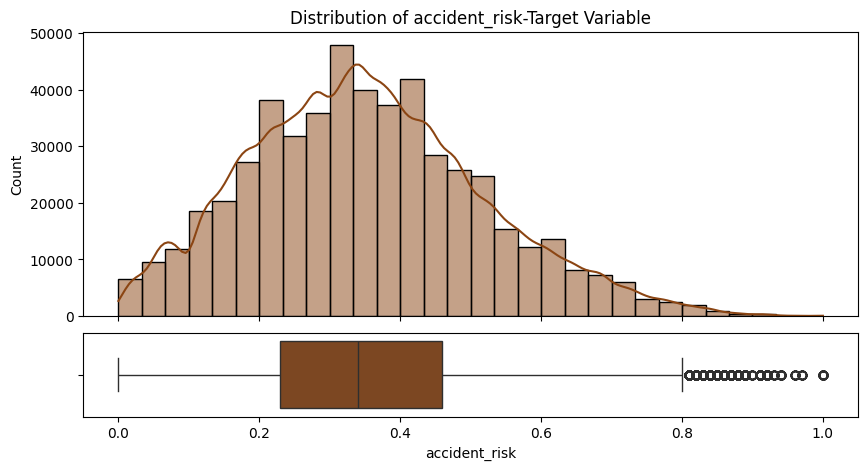

In [11]:
# Distribution of Target Variable
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(4, 1, hspace=0.2) 
ax_hist = fig.add_subplot(grid[0:3, 0]) 
ax_box = fig.add_subplot(grid[3, 0], sharex=ax_hist)

sns.histplot(train['accident_risk'], bins=30, kde=True, color='saddlebrown', ax=ax_hist, legend=False)
ax_hist.set_title("Distribution of accident_risk-Target Variable")
ax_hist.set_xlabel("")

sns.boxplot(x=train['accident_risk'], ax=ax_box, color='saddlebrown')
ax_box.set_xlabel("accident_risk")

plt.setp(ax_hist.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

The target variable is right-skewed with most values are between 0.2-0.5 (moderate-low risk), and contains outliers above 0.8 that need careful handling to avoid prediction bias but for starting we will use robust model which are less sensitive to outlier-randomforest, gradientboosting, xgboost etc

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Numeric feature distribution
</div>


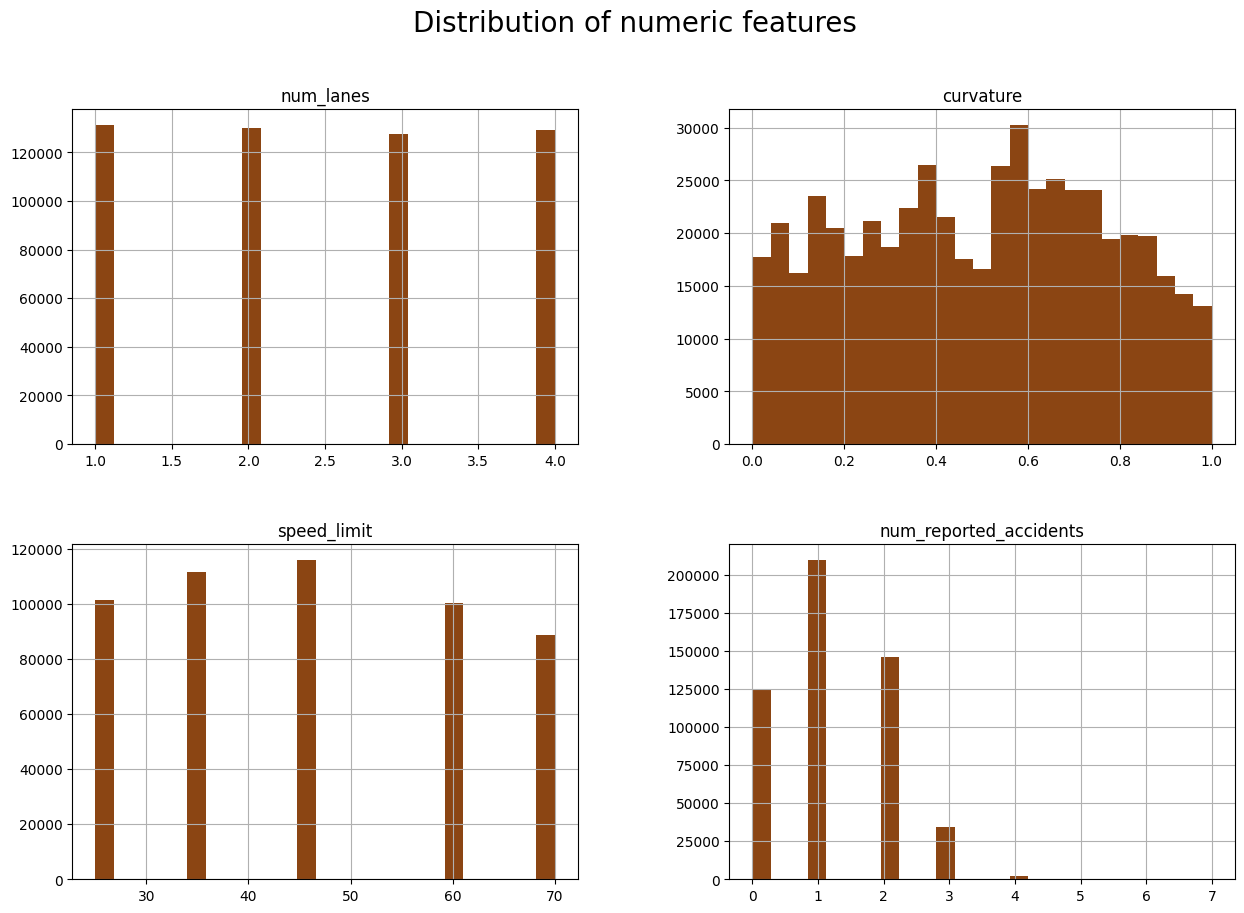

In [12]:
# Distribution of numeric features with histplot
train[numeric_features].hist(bins=25, figsize=(15,10), color='saddlebrown')
plt.suptitle('Distribution of numeric features', fontsize=20)
plt.show()



<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Categorical Features Distribution</div>


The Unique values of categorical features are:

road_type ['urban' 'rural' 'highway']
lighting ['daylight' 'dim' 'night']
weather ['rainy' 'clear' 'foggy']
time_of_day ['afternoon' 'evening' 'morning']


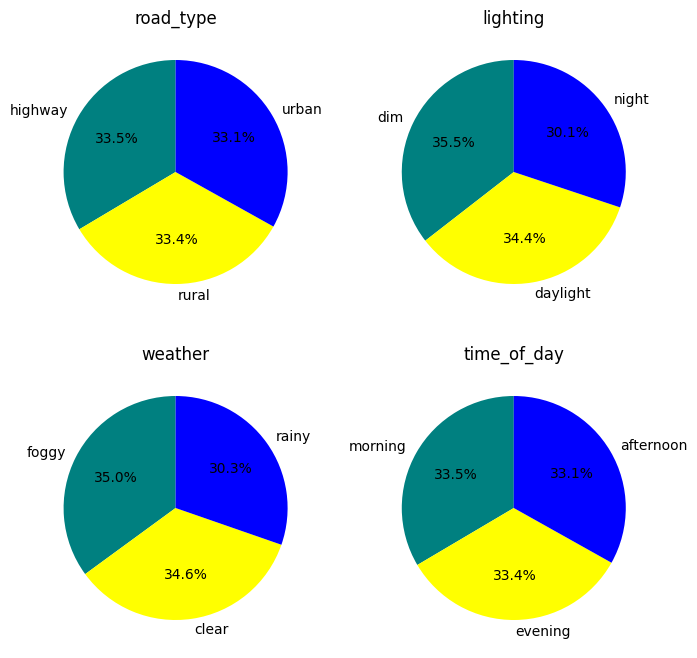

In [13]:
#show the unique values of categorical features
categorical_features = train.select_dtypes(include=['object']).columns
print("The Unique values of categorical features are:\n")
for i in categorical_features:
    print(i,train[i].unique())
#plot a pieplot for each categorical feature make it in a single figure with two above and two down
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].pie(train[categorical_features[0]].value_counts(), labels=train[categorical_features[0]].value_counts().index, autopct='%1.1f%%', startangle=90, colors=['teal', 'yellow', 'blue'])
axes[0, 0].set_title(categorical_features[0], fontsize=12)

# Pie chart 2 (top-right)
axes[0, 1].pie(train[categorical_features[1]].value_counts(), labels=train[categorical_features[1]].value_counts().index, autopct='%1.1f%%', startangle=90, colors=['teal', 'yellow', 'blue'])
axes[0, 1].set_title(categorical_features[1], fontsize=12)

# Pie chart 3 (bottom-left)
axes[1, 0].pie(train[categorical_features[2]].value_counts(), labels=train[categorical_features[2]].value_counts().index, autopct='%1.1f%%', startangle=90, colors=['teal', 'yellow', 'blue'])
axes[1, 0].set_title(categorical_features[2], fontsize=12)

# Pie chart 4 (bottom-right)
axes[1, 1].pie(train[categorical_features[3]].value_counts(), labels=train[categorical_features[3]].value_counts().index, autopct='%1.1f%%', startangle=90, colors=['teal', 'yellow', 'blue'])
axes[1, 1].set_title(categorical_features[3], fontsize=12)
plt.show()


<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
checking for ouliers
</div>

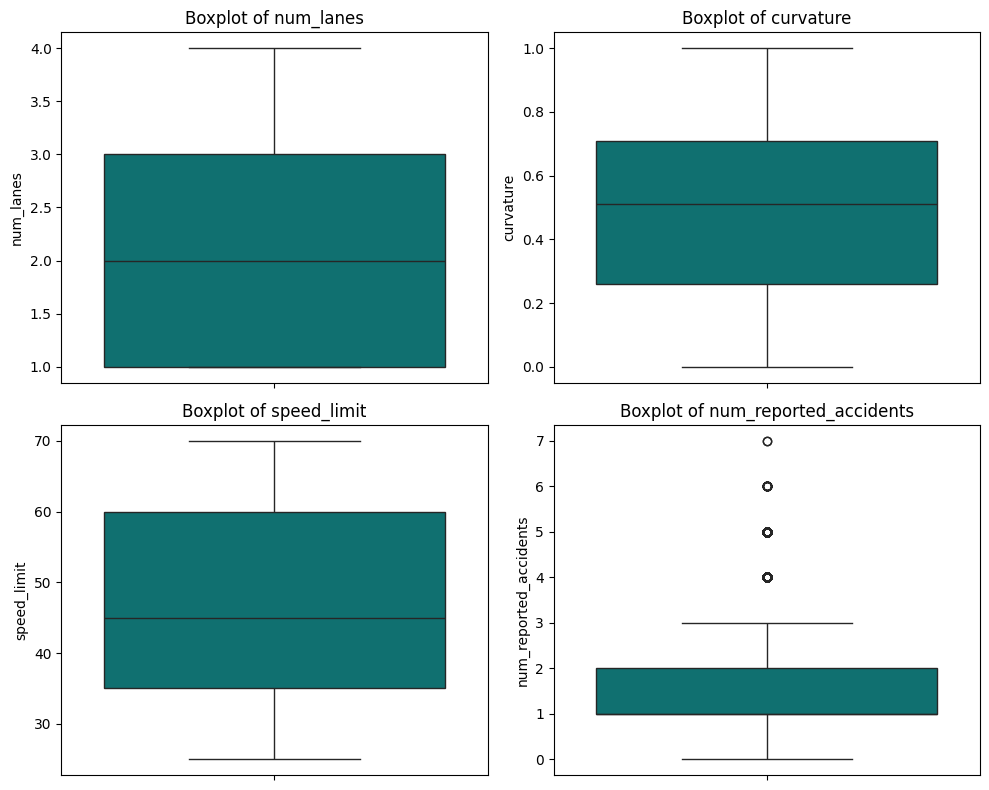

In [14]:
# Create a boxplot for each feature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes = axes.flatten()

for i, feature in enumerate(train[numeric_features]):
    sns.boxplot(data=train, y=feature, ax=axes[i], color='teal')
    axes[i].set_title(f'Boxplot of {feature}', fontsize=12)
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

The num_reported_accidents column is having outliers, but we will not remove them as this would lose valueable information about the most dangerous road segments

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Checking Correlation
</div>

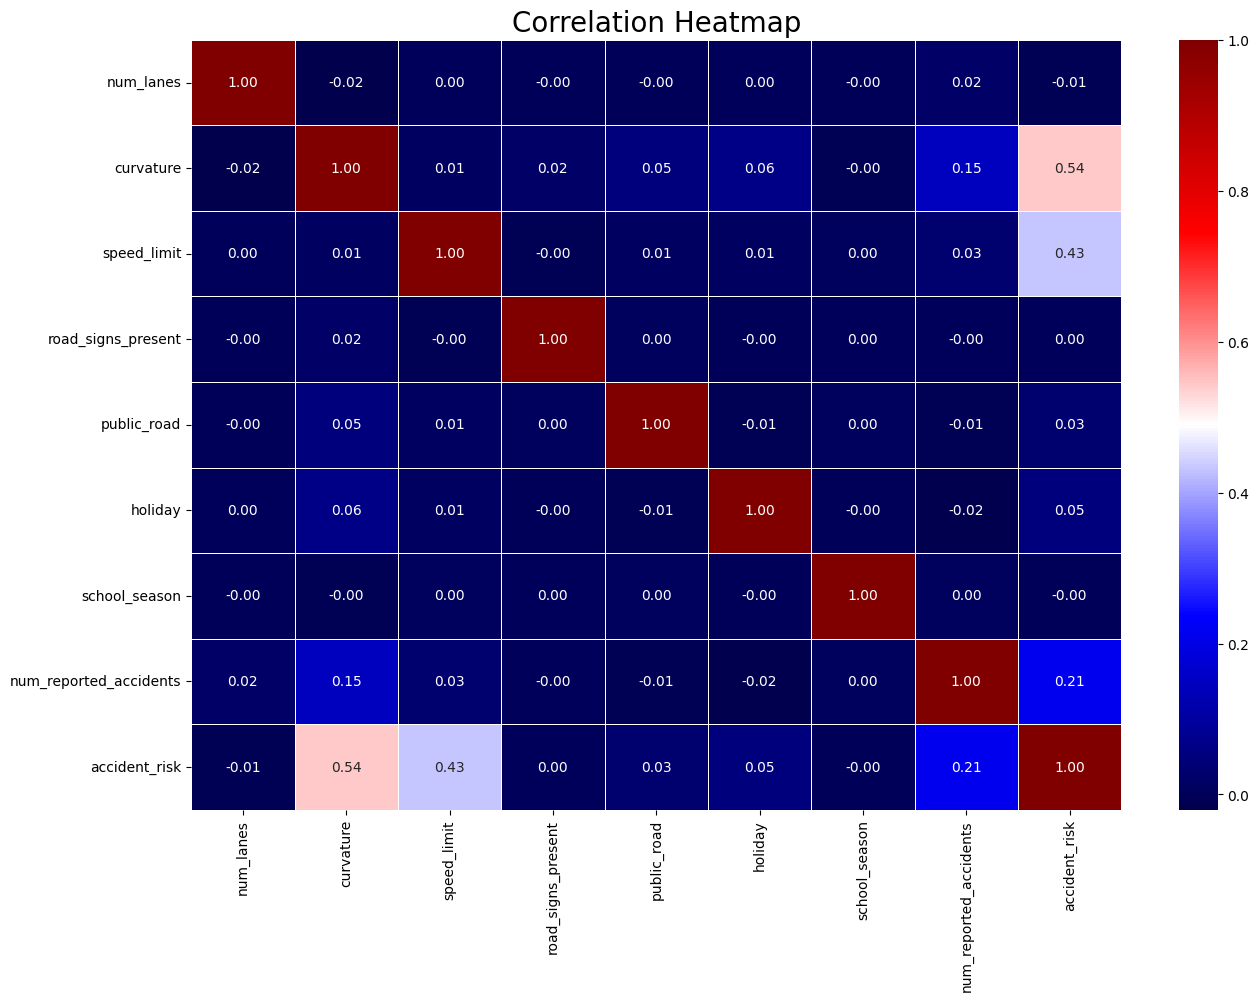

In [15]:
#Heatmap 
#include all the features excludong id and category features
plt.figure(figsize=(15, 10))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(train[['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']].corr(), annot=True, cmap='seismic', fmt='.2f', linewidths=0.5)
plt.show()



The heatmap shows that the features with contributes the most are Curvature, speed_limit. num_reported_accidents is directly proportional to accident_risk so that also moderate. The feature with negligible contribution are road_signs_present and school_season which can be removed.

### Data Preprocessing

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Column transformation
</div>

In [16]:
train_engineered = train.copy()
test_engineered = test.copy()

In [17]:
#Drop id column
train_engineered.drop(['id'], axis=1, inplace=True)
test_engineered.drop(['id'], axis=1, inplace=True)

<div style="background-color:#11288F; padding:7px; border-radius:7px; text-align:left; color:white; font-size:16px; ">
Encoding
</div>

In [18]:
#label encoding the categorical features
for col in categorical_features:
    le = LabelEncoder()
    train_engineered[col] = le.fit_transform(train_engineered[col])
    test_engineered[col] = le.transform(test_engineered[col])


In [19]:
#Boolean features encoding
train_engineered[boolean_features] = train_engineered[boolean_features].astype(int)
test_engineered[boolean_features] = test_engineered[boolean_features].astype(int)

### Feature engineering



new features to add
* Speed × Curvature (sharp curves at high speed = very dangerous)
* Speed × Bad Weather
* Curvature × Multiple Lanes (complex maneuvering)
* Poor Visibility Score
* Bad weather × poor lighting
* Accident_history_log
* curve_lane_risk
* Extreme Risk Flag



In [20]:
#  Curvature × Multiple Lanes
train_engineered['curve_lane_risk'] = train_engineered['curvature'] * train_engineered['num_lanes']
#  Extreme Risk Flag (triple threat)
train_engineered['extreme_risk'] = (
    (train_engineered['weather'] != 'clear') & 
    (train_engineered['lighting'] != 'daylight') & 
    (train_engineered['speed_limit'] > 60)
).astype(int)
# Speed × Lanes - High likelihood of success
train_engineered['speed_lanes_risk'] = train_engineered['speed_limit'] * train_engineered['num_lanes']

#sharp curve
train_engineered['sharp_curve_high_speed'] = (
    (train_engineered['curvature'] > train_engineered['curvature'].quantile(0.75)) & 
    (train_engineered['speed_limit'] > 60)
).astype(int)

print("Added 4 new features")
print(f"Total features: {train_engineered.shape[1]}")

# Display new features
new_features = ['curve_lane_risk', 
                 'extreme_risk','speed_lanes_risk',
                 'sharp_curve_high_speed',]
                 
print("\nNew features created:")
for feat in new_features:
    print(f"  • {feat}")

Added 4 new features
Total features: 17

New features created:
  • curve_lane_risk
  • extreme_risk
  • speed_lanes_risk
  • sharp_curve_high_speed


In [21]:

#  Curvature × Multiple Lanes
test_engineered['curve_lane_risk'] = test_engineered['curvature'] * test_engineered['num_lanes']
#  Extreme Risk Flag (triple threat)
test_engineered['extreme_risk'] = (
    (test_engineered['weather'] != 'clear') & 
    (test_engineered['lighting'] != 'daylight') & 
    (test_engineered['speed_limit'] > 60)
).astype(int)
# Speed × Lanes - High likelihood of success
test_engineered['speed_lanes_risk'] = test_engineered['speed_limit'] * test_engineered['num_lanes']

#sharp curve
test_engineered['sharp_curve_high_speed'] = (
    (test_engineered['curvature'] > test_engineered['curvature'].quantile(0.75)) & 
    (test_engineered['speed_limit'] > 60)
).astype(int)

In [22]:
#remove features that are not required
train_engineered = train_engineered.drop(columns=['road_signs_present','time_of_day','school_season', 'curve_lane_risk',
 "extreme_risk", 'speed_lanes_risk'])


In [23]:
test_engineered = test_engineered.drop(columns=['road_signs_present','time_of_day','school_season', 'curve_lane_risk',
 "extreme_risk", 'speed_lanes_risk'])

In [24]:
train_engineered.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,public_road,holiday,num_reported_accidents,accident_risk,sharp_curve_high_speed
0,2,2,0.06,35,0,2,1,0,1,0.13,0
1,2,4,0.99,35,0,0,0,1,0,0.35,0
2,1,4,0.63,70,1,0,1,1,2,0.30,0
3,0,4,0.07,35,1,2,1,0,1,0.21,0
4,1,1,0.58,60,0,1,0,1,1,0.56,0


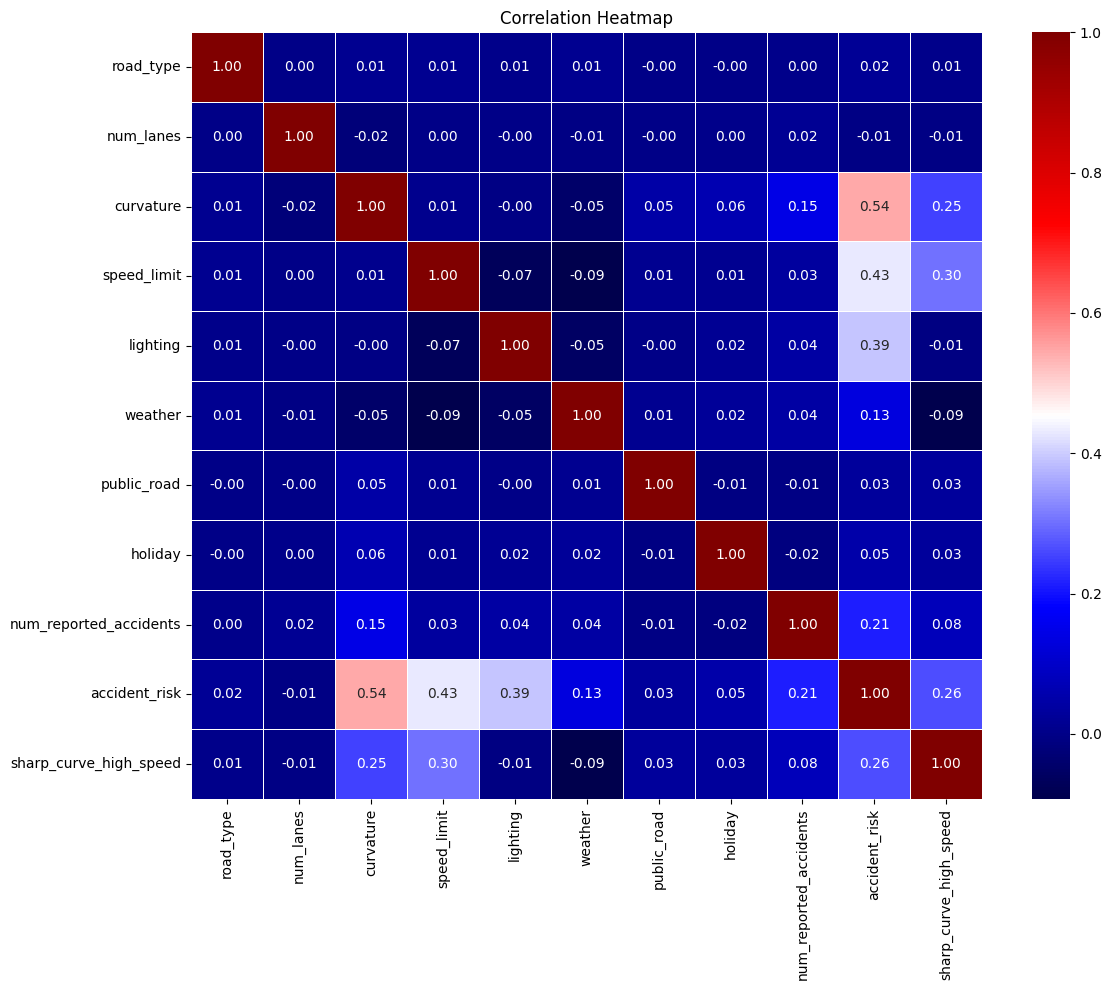

In [25]:
#heatmap
plt.figure(figsize=(12,10))
sns.heatmap(train_engineered.corr(), annot=True, cmap='seismic', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


### Model Creation

In [29]:
#prepare the data
X = train_engineered.drop(columns=['accident_risk'])
y = train_engineered['accident_risk']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [30]:
#model training
from tabnanny import verbose

def train_models(X_train, y_train,X_test,y_test):
    models = {
        'RandomForest': RandomForestRegressor(),
        'XGBoost': XGBRegressor(),
        'LightGBM': LGBMRegressor(verbose=-1),
        'CatBoost': CatBoostRegressor(verbose=0)
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f'{name}: RMSE = {rmse}')

train_models(X_train, y_train,X_test,y_test)        

RandomForest: RMSE = 0.06322583001633159
XGBoost: RMSE = 0.056311747356613547
LightGBM: RMSE = 0.05634826748807296
CatBoost: RMSE = 0.05622459209953158


### Hyperparameter tuning

In [31]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'random_strength': [0.5, 1.0, 1.5],
    'bagging_temperature': [0.5, 1.0, 2.0]
}

# Initialize the base model
cat_model = CatBoostRegressor(verbose=0)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,             
    cv=5,         
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,    
    verbose=1              
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'random_strength': 1.5, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 6, 'bagging_temperature': 2.0}
Best score: -0.05620529806627224


### submission file creation

In [ ]:
#predict on the best_model for test.csv and create a submisson file with id, accident_risk columns

id = test["id"]
ypred = best_model.predict(test_engineered)
submission = pd.DataFrame({"id": id, "accident_risk": ypred})
submission.to_csv("submission.csv", index=False)